# Seismic Interpretation for Oil Exploration

1. Seismic anlaysis 

In [6]:
import requests
import pandas as pd

# Define the endpoint URL for the USGS earthquake API
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"

# Define parameters to query the API
params = {
    "format": "geojson",  # Return data in GeoJSON format
    "starttime": "2020-01-01",  # Start time
    "endtime": "2021-01-01",    # End time
    "minmagnitude": 5.0,        # Minimum magnitude of earthquake
    "maxmagnitude": 9.0,        # Maximum magnitude of earthquake
    "limit": 1000,              # Limit the number of results to 1000
}

# Make a GET request to the API
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    print("Data fetched successfully!")
    earthquake_data = response.json()
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

# Extract relevant information (coordinates, magnitude, place, etc.)
features = earthquake_data['features']
earthquake_list = []

for feature in features:
    properties = feature['properties']
    geometry = feature['geometry']
    
    # Extract data: magnitude, place, time, latitude, longitude, depth
    magnitude = properties['mag']
    place = properties['place']
    time = properties['time']
    latitude = geometry['coordinates'][1]
    longitude = geometry['coordinates'][0]
    depth = geometry['coordinates'][2]
    
    earthquake_list.append([magnitude, place, time, latitude, longitude, depth])

# Convert the data to a Pandas DataFrame
earthquake_df = pd.DataFrame(earthquake_list, columns=['Magnitude', 'Place', 'Time', 'Latitude', 'Longitude', 'Depth'])

# Show the first few rows of the DataFrame
print(earthquake_df.head())


Data fetched successfully!
   Magnitude                                     Place           Time  \
0        5.2  144 km NNW of Lorengau, Papua New Guinea  1609444217399   
1        5.1           15 km SSE of Maumere, Indonesia  1609409934508   
2        5.0        7 km NNW of Shingli Bala, Pakistan  1609306423546   
3        5.0           4 km ENE of Funaishikawa, Japan  1609288527718   
4        5.7                central Mid-Atlantic Ridge  1609284897647   

   Latitude  Longitude   Depth  
0   -0.8052   146.8411   10.00  
1   -8.7445   122.2829  130.13  
2   34.7410    72.9466   10.00  
3   36.4858   140.6097   43.47  
4   -0.7603   -21.1005   10.00  


         Magnitude     Latitude    Longitude        Depth
count  1000.000000  1000.000000  1000.000000  1000.000000
mean      5.360530    -0.355054    19.602465    55.335430
std       0.409964    31.711379   123.383954   108.874724
min       5.000000   -65.352200  -179.962100     2.700000
25%       5.100000   -20.764100   -84.899475    10.000000
50%       5.200000    -5.060900    50.287350    10.000000
75%       5.500000    24.900350   138.626800    45.042500
max       7.800000    87.386000   179.923600   639.880000


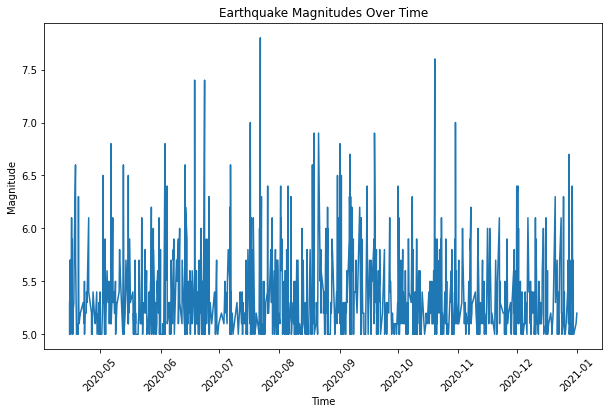

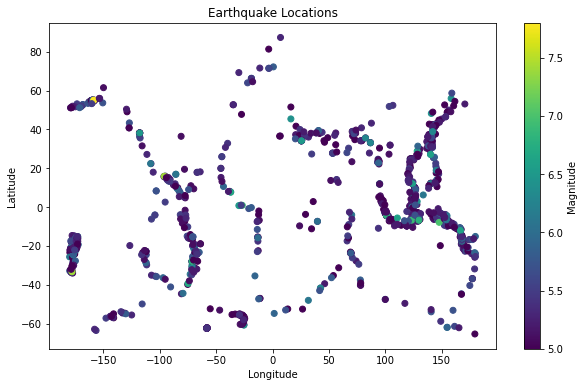

In [10]:
import matplotlib.pyplot as plt
# Summary statistics of the dataset
print(earthquake_df.describe())

# Plot earthquake magnitudes over time
earthquake_df['Time'] = pd.to_datetime(earthquake_df['Time'], unit='ms')  # Convert time to datetime format
plt.figure(figsize=(10,6))
plt.plot(earthquake_df['Time'], earthquake_df['Magnitude'], label='Magnitude')
plt.title('Earthquake Magnitudes Over Time')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.xticks(rotation=45)
plt.show()

# Plot earthquake locations (latitude and longitude)
plt.figure(figsize=(10,6))
plt.scatter(earthquake_df['Longitude'], earthquake_df['Latitude'], c=earthquake_df['Magnitude'], cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('Earthquake Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## . K-Means Clustering of Earthquakes
K-Means Clustering was applied to group earthquake events into 3 clusters based on their geographical location (latitude, longitude), depth, and magnitude.
Each cluster is visualized in a different color, showing potential zones of similar seismic activity.

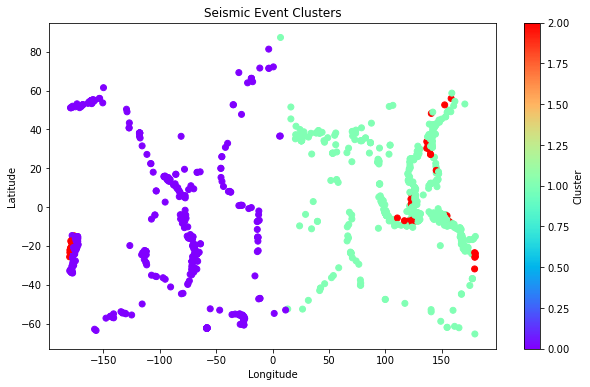

In [11]:
from sklearn.cluster import KMeans

# Select relevant features for clustering (latitude, longitude, depth, magnitude)
X = earthquake_df[['Latitude', 'Longitude', 'Depth', 'Magnitude']]

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
earthquake_df['Cluster'] = kmeans.fit_predict(X)

# Visualize the clusters
plt.figure(figsize=(10,6))
plt.scatter(earthquake_df['Longitude'], earthquake_df['Latitude'], c=earthquake_df['Cluster'], cmap='rainbow')
plt.title('Seismic Event Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()


In [13]:
# Create a new 'Risk_Level' column based on magnitude
def classify_risk(magnitude):
    if magnitude < 5.5:
        return 'Low'
    elif 5.5 <= magnitude < 6.5:
        return 'Medium'
    else:
        return 'High'

earthquake_df['Risk_Level'] = earthquake_df['Magnitude'].apply(classify_risk)

# Now, you can use 'Risk_Level' for classification
X = earthquake_df[['Magnitude', 'Depth', 'Latitude', 'Longitude']]  # Features
y = earthquake_df['Risk_Level']  # Target

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = rf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        High       1.00      1.00      1.00         8
         Low       1.00      1.00      1.00       130
      Medium       1.00      1.00      1.00        62

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



### Risk Level Classification with Random Forest
A new column, Risk_Level, was created based on earthquake magnitudes:

     Magnitude < 5.5: Low
     5.5 ≤ Magnitude < 6.5: Medium
     Magnitude ≥ 6.5: High
The Random Forest Classifier was trained to predict the earthquake risk level based on features like magnitude, depth, latitude, and longitude.
The classifier achieved perfect accuracy with precision, recall, and F1-scores of 1.00 for all classes.

In [14]:
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importances.sort_values(by='Importance', ascending=False))


The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
     Feature  Importance
0  Magnitude    0.955821
3  Longitude    0.016272
1      Depth    0.016079
2   Latitude    0.011829


### 1. Synthetic Data for Oil Exploration:

You can simulate synthetic seismic data that represents subsurface rock layers with potential oil reservoirs.

In [15]:
import numpy as np
import pandas as pd

# Number of seismic data points (representing layers)
n_points = 1000

# Generate synthetic seismic features
depth = np.random.uniform(1000, 5000, n_points)  # Depth in meters
amplitude = np.random.uniform(0, 1, n_points)    # Seismic reflection amplitude
frequency = np.random.uniform(5, 50, n_points)   # Seismic wave frequency
velocity = np.random.uniform(1000, 5000, n_points)  # Wave velocity in m/s

# Generate target variable: 1 for oil-bearing, 0 for non-oil-bearing
# Higher amplitude and certain frequency ranges are more likely to indicate oil
oil_bearing = (amplitude > 0.6) & (frequency > 20)  # This is just a simplification

# Create DataFrame
seismic_df = pd.DataFrame({
    'Depth': depth,
    'Amplitude': amplitude,
    'Frequency': frequency,
    'Velocity': velocity,
    'Oil_Bearing': oil_bearing.astype(int)  # Binary target
})

# Show first few rows
print(seismic_df.head())


         Depth  Amplitude  Frequency     Velocity  Oil_Bearing
0  2816.079371   0.890137  37.653348  2695.365458            1
1  4188.455771   0.649527   8.993696  1039.552373            0
2  3440.919867   0.835047  43.088343  1176.134261            1
3  3682.072430   0.219575  13.388824  4344.543031            0
4  2795.706110   0.757342   5.991061  2170.951362            0


### 2.  Machine Learning Model for Oil Prediction:

You can use a Random Forest classifier to predict whether a certain seismic reading indicates an oil-bearing structure.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define features (depth, amplitude, frequency, velocity)
X = seismic_df[['Depth', 'Amplitude', 'Frequency', 'Velocity']]

# Define the target (whether oil-bearing or not)
y = seismic_df['Oil_Bearing']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00        50

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



### 3. Feature Importance for Oil Exploration:

You can check the most important features that predict whether an area is oil-bearing based on the seismic data.

In [17]:
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importances.sort_values(by='Importance', ascending=False))


     Feature  Importance
1  Amplitude    0.645403
2  Frequency    0.331638
3   Velocity    0.012165
0      Depth    0.010794


## Hyperparameter Tuning with RandomizedSearchCV

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Use RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
random_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters: ", random_search.best_params_)

# Evaluate the best model
best_rf = random_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_best))


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00        50

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



     Feature  Importance
1  Amplitude    0.662913
2  Frequency    0.322262
3   Velocity    0.007734
0      Depth    0.007091


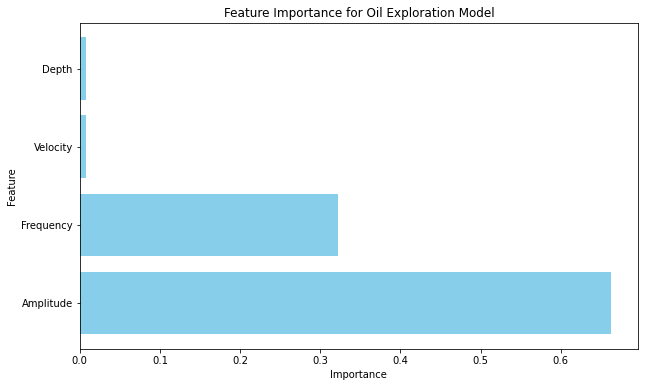

In [19]:
importances = best_rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Print and plot feature importance
print(feature_importances)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Oil Exploration Model')
plt.show()


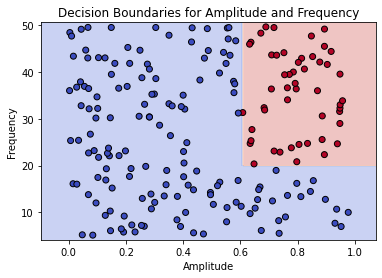

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Plot decision boundaries for the two most important features
X_plot = X_test[['Amplitude', 'Frequency']].values
y_plot = y_test.values

# Fit a small classifier using only these two features for visualization purposes
rf_small = RandomForestClassifier(n_estimators=100, random_state=42)
rf_small.fit(X_plot, y_plot)

# Create a meshgrid of values for amplitude and frequency
x_min, x_max = X_plot[:, 0].min() - 0.1, X_plot[:, 0].max() + 0.1
y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.5))

# Predict on the meshgrid to get decision boundaries
Z = rf_small.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and data points
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, edgecolors='k', cmap=plt.cm.coolwarm)
plt.title('Decision Boundaries for Amplitude and Frequency')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.show()
